# interfacing pandas and model code

In [164]:
import pandas as pd
import numpy as np
import patsy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
%matplotlib inline

In [23]:
df1 = pd.DataFrame({'x0':[1,2,3,4,5],
                    'x1':[0.01,-0.01,0.25,-4.1,0],
                    'y':[-1.5,0,3.6,1.3,-2]})
df1

,x0,x1,y
0,1,0.01,-1.5
1,2,-0.01,0.0
2,3,0.25,3.6
3,4,-4.10,1.3
4,5,0.00,-2.0


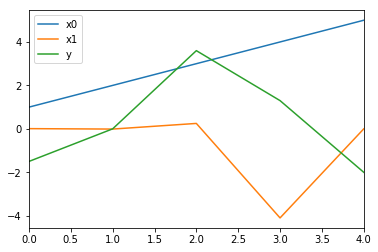

In [5]:
df1.plot()

In [6]:
df1.values # 变成array

array([[ 1.  ,  0.01, -1.5 ],
       [ 2.  , -0.01,  0.  ],
       [ 3.  ,  0.25,  3.6 ],
       [ 4.  , -4.1 ,  1.3 ],
       [ 5.  ,  0.  , -2.  ]])

In [7]:
pd.DataFrame(df1.values)

,0,1,2
0,1.0,0.01,-1.5
1,2.0,-0.01,0.0
2,3.0,0.25,3.6
3,4.0,-4.10,1.3
4,5.0,0.00,-2.0


In [8]:
df1['string'] = list('abcde')

In [9]:
df1.values # 注意右下角的dtype = object，同为数字时是没有这个的

array([[1, 0.01, -1.5, 'a'],
       [2, -0.01, 0.0, 'b'],
       [3, 0.25, 3.6, 'c'],
       [4, -4.1, 1.3, 'd'],
       [5, 0.0, -2.0, 'e']], dtype=object)

In [11]:
df1.loc[:,['x0','x1']].values # 右下角的dtype没有

array([[ 1.  ,  0.01],
       [ 2.  , -0.01],
       [ 3.  ,  0.25],
       [ 4.  , -4.1 ],
       [ 5.  ,  0.  ]])

In [14]:
df1.drop('string',axis = 1,inplace = True)

In [24]:
df1['category'] = pd.Categorical(['a','b','a','a','b'],categories = ['a','b'])

In [26]:
df1.drop('category',axis = 1).join(pd.get_dummies((df1.category),prefix = 'category'))  
# drop中不能传入inplace = True,因为代码是从左往右运行的，df1中已经没有了category这列，join就无从下手

,x0,x1,y,category_a,category_b
0,1,0.01,-1.5,1,0
1,2,-0.01,0.0,0,1
2,3,0.25,3.6,1,0
3,4,-4.10,1.3,1,0
4,5,0.00,-2.0,0,1


# creating model description with pasty

In [28]:
df2 = df1.drop('category',axis = 1)
df2

,x0,x1,y
0,1,0.01,-1.5
1,2,-0.01,0.0
2,3,0.25,3.6
3,4,-4.10,1.3
4,5,0.00,-2.0


In [31]:
y,x = patsy.dmatrices('y ~ x0 + x1',df2)

In [32]:
y

DesignMatrix with shape (5, 1)
     y
  -1.5
   0.0
   3.6
   1.3
  -2.0
  Terms:
    'y' (column 0)

In [33]:
x

DesignMatrix with shape (5, 3)
  Intercept  x0     x1
          1   1   0.01
          1   2  -0.01
          1   3   0.25
          1   4  -4.10
          1   5   0.00
  Terms:
    'Intercept' (column 0)
    'x0' (column 1)
    'x1' (column 2)

In [34]:
np.array(y)

array([[-1.5],
       [ 0. ],
       [ 3.6],
       [ 1.3],
       [-2. ]])

In [35]:
np.array(x)

array([[ 1.  ,  1.  ,  0.01],
       [ 1.  ,  2.  , -0.01],
       [ 1.  ,  3.  ,  0.25],
       [ 1.  ,  4.  , -4.1 ],
       [ 1.  ,  5.  ,  0.  ]])

In [41]:
coef,resid,a,b = np.linalg.lstsq(x,y)

In [44]:
resid

array([ 19.63791494])

In [42]:
a

3

In [37]:
coef

array([[ 0.31290976],
       [-0.07910564],
       [-0.26546384]])

In [45]:
coef1 = pd.Series(coef.squeeze(),index = x.design_info.column_names)
coef1[1:3]

x0   -0.079106
x1   -0.265464
dtype: float64

In [46]:
type(coef1)

pandas.core.series.Series

In [49]:
df1[['x0','x1']]

,x0,x1
0,1,0.01
1,2,-0.01
2,3,0.25
3,4,-4.10
4,5,0.00


In [52]:
df2 = coef1[1:3] * df1[['x0','x1']]
df1['y_pred'] = df2['x0'] + df2['x1'] + coef1[0]

In [53]:
df1

,x0,x1,y,category,y_pred
0,1,0.01,-1.5,a,0.231149
1,2,-0.01,0.0,b,0.157353
2,3,0.25,3.6,a,0.009227
3,4,-4.10,1.3,a,1.084889
4,5,0.00,-2.0,b,-0.082618


In [71]:
df1.loc[0,'x1'] - df1['x1'].mean()

0.77999999999999992

In [76]:
(1 - 3) / (df1.x0.std() ** 2)

-0.79999999999999982

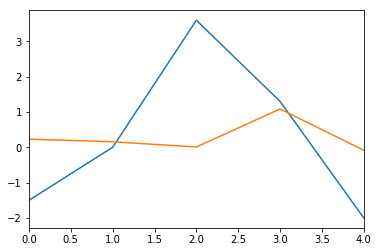

In [60]:
df1.y.plot()
df1.y_pred.plot()

In [69]:
y,x = patsy.dmatrices('y ~ x0 + np.log(np.abs(x1) + 1)',df1)
coef3 = np.linalg.lstsq(x,y)[0]
pd.Series(coef3.squeeze(),index = x.design_info.column_names)

Intercept                 0.330730
x0                       -0.183632
np.log(np.abs(x1) + 1)    1.335711
dtype: float64

In [62]:
x

DesignMatrix with shape (5, 3)
  Intercept  x0  np.log(np.abs(x1) + 1)
          1   1                 0.00995
          1   2                 0.00995
          1   3                 0.22314
          1   4                 1.62924
          1   5                 0.00000
  Terms:
    'Intercept' (column 0)
    'x0' (column 1)
    'np.log(np.abs(x1) + 1)' (column 2)

In [79]:
y,x = patsy.dmatrices('y ~ standardize(x0) + center(x1)',df1) 
# center:减去这一列的平均数 standardize
coef2,resid,_,_ = np.linalg.lstsq(x,y)
pd.Series(coef2.squeeze(),index = x.design_info.column_names) 

Intercept          0.280000
standardize(x0)   -0.111872
center(x1)        -0.265464
dtype: float64

In [81]:
x

DesignMatrix with shape (5, 3)
  Intercept  standardize(x0)  center(x1)
          1         -1.41421        0.78
          1         -0.70711        0.76
          1          0.00000        1.02
          1          0.70711       -3.33
          1          1.41421        0.77
  Terms:
    'Intercept' (column 0)
    'standardize(x0)' (column 1)
    'center(x1)' (column 2)

In [80]:
x2 = patsy.build_design_matrices([x.design_info],df1)
x2

[DesignMatrix with shape (5, 3)
   Intercept  standardize(x0)  center(x1)
           1         -1.41421        0.78
           1         -0.70711        0.76
           1          0.00000        1.02
           1          0.70711       -3.33
           1          1.41421        0.77
   Terms:
     'Intercept' (column 0)
     'standardize(x0)' (column 1)
     'center(x1)' (column 2)]

In [82]:
y,x3 = patsy.dmatrices('y ~ I(x0 + x1)',df1) # I 括号里面的才是真正的相加
x3 

DesignMatrix with shape (5, 2)
  Intercept  I(x0 + x1)
          1        1.01
          1        1.99
          1        3.25
          1       -0.10
          1        5.00
  Terms:
    'Intercept' (column 0)
    'I(x0 + x1)' (column 1)

In [83]:
df1.x0 + df1.x1 # 看看，和上面的相加结果相同

0    1.01
1    1.99
2    3.25
3   -0.10
4    5.00
dtype: float64

In [84]:
df2 = pd.DataFrame({
    'key1':['a','a','b','b','a','b','a','b'],
    'key2':[0,1,0,1,0,1,0,0],
    'v1':list(range(1,9)),
    'v2':[-1,0,2.5,-0.5,4.0,-1.2,0.2,-1.7]
})

In [86]:
y4,x4 = patsy.dmatrices('v2 ~ key1',df2)

In [88]:
x4 # key1中是非数字的，dummies了之后发现只有b，而没有a，怎么办？看下面的

DesignMatrix with shape (8, 2)
  Intercept  key1[T.b]
          1          0
          1          0
          1          1
          1          1
          1          0
          1          1
          1          0
          1          1
  Terms:
    'Intercept' (column 0)
    'key1' (column 1)

In [89]:
y4,x5 = patsy.dmatrices('v2 ~ key1 + 0',df2)

In [90]:
x5 # 

DesignMatrix with shape (8, 2)
  key1[a]  key1[b]
        1        0
        1        0
        0        1
        0        1
        1        0
        0        1
        1        0
        0        1
  Terms:
    'key1' (columns 0:2)

In [91]:
# 纯数字的列也能被解释成categorical，当然要用到一个方程C
y4,x6 = patsy.dmatrices('v2 ~ C(key2)',df2)

In [92]:
x6

DesignMatrix with shape (8, 2)
  Intercept  C(key2)[T.1]
          1             0
          1             1
          1             0
          1             1
          1             0
          1             1
          1             0
          1             0
  Terms:
    'Intercept' (column 0)
    'C(key2)' (column 1)

In [94]:
y4,x7 = patsy.dmatrices('v2 ~ key1:key2',df2)

In [95]:
x7

DesignMatrix with shape (8, 3)
  Intercept  key1[a]:key2  key1[b]:key2
          1             0             0
          1             1             0
          1             0             0
          1             0             1
          1             0             0
          1             0             1
          1             0             0
          1             0             0
  Terms:
    'Intercept' (column 0)
    'key1:key2' (columns 1:3)

# introduction to statsmodels

In [101]:
def dnorm(mean,variance,size = 1):
    if isinstance(size,int):
        size = size
    return mean + np.sqrt(variance) * np.random.randn(size)

In [104]:
N = 100
x = np.c_[dnorm(0,0.4,size = N), # 和zip函数一样，和merge也很像
          dnorm(0,0.6,size = N),
          dnorm(0,0.2,size = N)]
x[:5] # 生成了一个100行，三列的一个数

array([[-0.65010388,  1.63634067, -0.56097801],
       [ 0.45849666, -1.86596867, -0.07717733],
       [-1.16163852,  0.80651708, -0.38429433],
       [-0.66034386,  0.12661479,  0.27526392],
       [ 0.08737664, -0.56780027,  0.49645867]])

In [105]:
eps = dnorm(0,0.1,size = N)
beta = [0.1,0.3,0.5]
y = np.dot(x,beta) + eps # dot 矩阵相乘，此时beta表现的更像是3行1列，y:100行1列
y[:5]

array([-0.00103763, -0.44252768,  0.38963887, -0.14188131,  0.18148626])

In [107]:
x_model = sm.add_constant(x)

In [108]:
model = sm.OLS(y,x) # 使用最小二乘法来拟合
result = model.fit()

In [115]:
arr1 = result.params #拟合出来的系数
arr1

array([ 0.08120898,  0.32765611,  0.3754961 ])

In [112]:
df1

,x0,x1,y,category,y_pred
0,1,0.01,-1.5,a,0.231149
1,2,-0.01,0.0,b,0.157353
2,3,0.25,3.6,a,0.009227
3,4,-4.10,1.3,a,1.084889
4,5,0.00,-2.0,b,-0.082618


In [113]:
result.predict(df1.iloc[:,:3]) # 还有一个原始的方法：

0   -0.478759
1    0.159141
2    1.677327
3   -0.530409
4   -0.344947
dtype: float64

In [119]:
(df1.iloc[:,:3] * arr1).sum(axis = 1)

0   -0.478759
1    0.159141
2    1.677327
3   -0.530409
4   -0.344947
dtype: float64

In [121]:
df3 = pd.DataFrame(x,columns = ['col1','col2','col3'])
df3['y'] = y

In [124]:
y,x = patsy.dmatrices('y ~ col1 + col2 + col3',df3)
coef5,resid,_,_ = np.linalg.lstsq(x,y)
s6 = pd.Series(coef5.squeeze(),index = x.design_info.column_names) 
s6

Intercept   -0.004988
col1         0.082304
col2         0.327713
col3         0.375691
dtype: float64

In [140]:
s6.reset_index()[0][1:]

1    0.082304
2    0.327713
3    0.375691
Name: 0, dtype: float64

In [147]:
df1.columns = [1,2,3,4,5]

In [152]:
df1

,1,2,3,4,5
0,1,0.01,-1.5,a,0.231149
1,2,-0.01,0.0,b,0.157353
2,3,0.25,3.6,a,0.009227
3,4,-4.10,1.3,a,1.084889
4,5,0.00,-2.0,b,-0.082618


In [151]:
(df1.loc[:,1:3] * s6.reset_index()[0][1:]).sum(axis = 1)

0   -0.477955
1    0.161331
2    1.681326
3   -0.526011
4   -0.339862
dtype: float64

In [157]:
df3

,col1,col2,col3,y
0,-0.650104,1.636341,-0.560978,-0.001038
1,0.458497,-1.865969,-0.077177,-0.442528
2,-1.161639,0.806517,-0.384294,0.389639
3,-0.660344,0.126615,0.275264,-0.141881
4,0.087377,-0.567800,0.496459,0.181486
5,-0.060486,0.817872,-0.406044,-0.097497
6,0.313960,0.603692,-0.085768,0.343572
7,-0.599112,1.189101,0.248797,0.919905
8,-0.828741,0.918793,-1.142692,-0.010215
9,-0.475086,-0.778704,0.825563,-0.233265


In [159]:
result2 = smf.ols('y ~ col1 + col2 + col3',data =df3 ).fit()
result2.params

Intercept   -0.004988
col1         0.082304
col2         0.327713
col3         0.375691
dtype: float64

In [160]:
result2.tvalues # 和params的区别在哪里呢？

Intercept   -0.142322
col1         1.403505
col2         7.418796
col3         4.634351
dtype: float64

In [163]:
result2.predict(df3[:5])

0    0.267002
1   -0.607750
2    0.019335
3    0.085570
4    0.002642
dtype: float64

In [170]:
init_x = 4
values = [init_x,init_x]
N = 1000
b0 = 0.8
b1 = -0.4
noise = dnorm(0,0.1,N)
for i in range(N):
    new_x = values[-1] * b0 + values[-2] * b1 + noise[i]
    values.append(new_x)

In [173]:
result3 = sm.tsa.AR(values).fit(5)
result3.params

array([ 0.01053265,  0.74079961, -0.34571682, -0.04595397, -0.01817804,
       -0.00256851])

In [174]:
result3.tvalues

array([  1.00790533,  23.32540104,  -8.74281009,  -1.1202529 ,
        -0.4636813 ,  -0.08476682])